In [1]:
# %reset -s -f


In [2]:
import pandas as pd
import numpy

Shape of our dataset (rows, columns): (100000, 3)

First 5 rows of the dataset:
   person_id  outcome  true_rate
0          1        0   0.050266
1          1        0   0.050266
2          1        0   0.050266
3          1        0   0.050266
4          1        0   0.050266


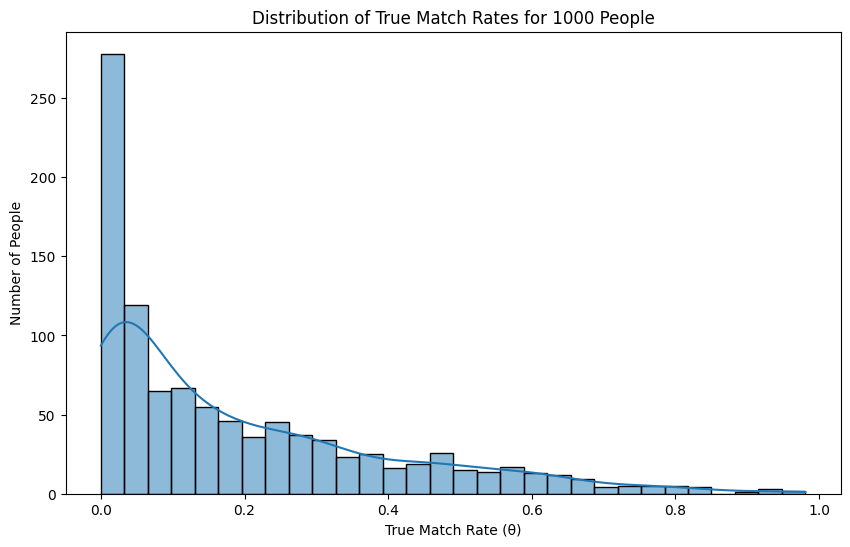

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the population distribution and generate a true_rate for each person
np.random.seed(42) # for reproducibility


population_alpha = 0.5
population_beta = 2
true_rates = np.random.beta(population_alpha, population_beta, 1000)

# Simulate 100 swipes for each of the 1000 people
all_swipes = []
for i in range(1000):
    person_id = i + 1
    # Use the true_rate we generated for this person
    person_true_rate = true_rates[i]
    # Simulate their 100 swipes
    outcomes = np.random.binomial(1, person_true_rate, 100)
    for outcome in outcomes:
        all_swipes.append({'person_id': person_id, 'outcome': outcome, 'true_rate': person_true_rate})

# Convert to a pandas DataFrame for easier handling
swipe_data = pd.DataFrame(all_swipes)

# --- Let's look at what we created ---
print("Shape of our dataset (rows, columns):", swipe_data.shape)
print("\nFirst 5 rows of the dataset:")
print(swipe_data.head())

observed_data = swipe_data[["person_id", "outcome"]]

# Visualize the distribution of the true underlying rates
plt.figure(figsize=(10, 6))
sns.histplot(true_rates, bins=30, kde=True)
plt.title('Distribution of True Match Rates for 1000 People')
plt.xlabel('True Match Rate (θ)')
plt.ylabel('Number of People')
plt.show()

In [ ]:
overall_theta = swipe_data["outcome"].sum()/swipe_data["outcome"].count()

In [23]:
overall_theta

np.float64(0.18958)

,person_id,outcome,true_rate
0,1,0,0.050266
1,1,0,0.050266
2,1,0,0.050266
3,1,0,0.050266
4,1,0,0.050266
...,...,...,...
99995,1000,0,0.044124
99996,1000,0,0.044124
99997,1000,0,0.044124
99998,1000,0,0.044124


###### Problem Statmemt:

- Here we have the 100K outcomes of 1000 persons on a dating site, whether they each of their swipe yielded a match or not...
- now we want to represent as a probabilistic model , and here we will take the probability of matching outcome is actually depends on an 
unknown parameter / distribution that decides the outcomes.. 



In [5]:
observed_data.head()

,person_id,outcome
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


## to get start with the probabilitisc model, we shall use the EDM, where it has two assumptions
- Each observation is an independent random variable that's from a distribution P(x|theta)
- the parameter of the distribution is coming from a prior distribution p(theta)

$$
p(\theta, \mathbf{x}) \;=\; p(\theta)\, \prod_{i=1}^{n} p(x_i \mid \theta).
$$


**Hierarchical Beta–Bernoulli (exchangeable people)**


\begin{aligned}
\alpha,\beta &\sim \text{Gamma}(2,2) \\
\theta_i \mid \alpha,\beta &\sim \text{Beta}(\alpha,\beta), \quad i=1,\dots,N \\
x_{i,t} \mid \theta_i &\sim \text{Bernoulli}(\theta_i), \quad t=1,\dots,n_i
\end{aligned}


Collapsed (integrating out \(\theta_i\)):



\begin{aligned}
s_i=\sum_{t=1}^{n_i} x_{i,t} \;\sim\; \text{BetaBinomial}\!\left(n_i,\; \alpha,\beta\right).
\end{aligned}


Posterior for each person (given \(\alpha,\beta\)):


\begin{aligned}
\theta_i \mid \text{data},\alpha,\beta \sim \text{Beta}(\alpha+s_i,\; \beta+n_i-s_i).
\end{aligned}

In [24]:
import pandas as pd, torch

# swipe_data: columns = [person_id, outcome ∈ {0,1}, true_rate]
g = swipe_data.groupby("person_id")["outcome"]
successes = torch.tensor(g.sum().to_numpy(), dtype=torch.float32)   # s_i
totals    = torch.tensor(g.count().to_numpy(), dtype=torch.float32) # n_i
person_ids = g.count().index.to_numpy()
N = len(person_ids)
print(N, "people")


1000 people


In [28]:
# import torch
# import pyro
# import pyro.distributions as dist
# import pyro.distributions.constraints as constraints

# def beta_bernoulli_model(n=None, alpha1=5.0, alpha0=10.0, obs=None):
#     # treat hyperparams as known (params so they show up in the graph)
#     a1 = pyro.param("alpha1", lambda: torch.tensor(alpha1), constraint=constraints.positive)
#     a0 = pyro.param("alpha0", lambda: torch.tensor(alpha0), constraint=constraints.positive)

#     # prior
#     theta = pyro.sample("pi", dist.Beta(a1, a0))

#     # data plate
#     if obs is not None:
#         n = len(obs)
#     assert n is not None, "Provide n (or pass obs)."

#     with pyro.plate("n", n):
#         pyro.sample("x_i", dist.Bernoulli(probs=theta), obs=obs)

# # --- Render (structure only) ---
# from pyro import render_model
# g = render_model(
#     beta_bernoulli_model,
#     model_kwargs={"n": 10000, "alpha1": 5.0, "alpha0": 10.0, "obs": None},
#     render_distributions=True
# )
# g  # displays in Jupyter


In [29]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import NUTS, MCMC

pyro.clear_param_store(); pyro.set_rng_seed(0)

def model_collapsed(successes, totals):
    # weakly-informative hyperpriors (positive support)
    alpha = pyro.sample("alpha", dist.Gamma(2.0, 2.0))
    beta  = pyro.sample("beta" , dist.Gamma(2.0, 2.0))
    with pyro.plate("people", len(totals)):
        # Collapsed: integrate out theta_i → Beta-Binomial on counts
        pyro.sample("s", dist.BetaBinomial(
            total_count=totals,
            concentration1=alpha,
            concentration0=beta
        ), obs=successes)

nuts = NUTS(model_collapsed, target_accept_prob=0.9, max_tree_depth=12)
mcmc = MCMC(nuts, warmup_steps=800, num_samples=1600, num_chains=1)
mcmc.run(successes, totals)

post = mcmc.get_samples()
alpha_draws, beta_draws = post["alpha"], post["beta"]         # shape [S]
print("alpha mean:", float(alpha_draws.mean()), " beta mean:", float(beta_draws.mean()))


Sample: 100%|█| 2400/2400 [00:06, 351.10it/s, step size=3.91e-01, acc. prob=0.96

alpha mean: 0.5022295117378235  beta mean: 2.1176233291625977
